# Let's analyze the BRO and BRO complex dataset

start training at `2016-03-10`

# Step 1: Load Data

In [71]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error

# load holidays
h = pd.read_csv('../data/holidays.csv')

# create a pandas dataframe object
df1 = pd.read_csv('../data/BRO_aht_vol.csv', parse_dates=['date'], index_col=0)

df1.head()


df1.index = df1['date']
display(df1.head())

df = df1.copy()

,date,handle_time,handle_time_forecast,volume,volume_forecast
date,,,,,
2016-01-01,2016-01-01,1317.0,NaN,6.0,0.0
2016-01-02,2016-01-02,0.0,NaN,0.0,0.0
2016-01-03,2016-01-03,0.0,NaN,0.0,0.0
2016-01-04,2016-01-04,500887.0,NaN,790.0,972.0
2016-01-05,2016-01-05,442528.0,NaN,631.0,844.0


In [72]:
# create column for aht
df['aht'] = df['handle_time']/df['volume']

df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']

# Step 2: Clean and Analyze Data

The boxplots below show several outliers near 0, and a long tail of values in the uppper ranges.

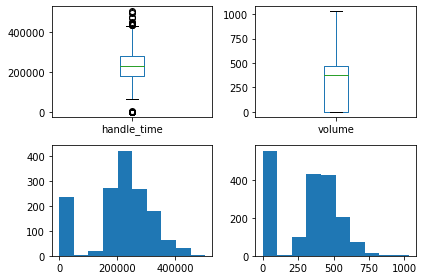

In [73]:
plt.subplot(221)
df['handle_time'].plot.box()

plt.subplot(222)
df['volume'].plot.box()

plt.subplot(223)
df['handle_time'].hist(grid=False)

plt.subplot(224)
df['volume'].hist(grid=False)
plt.tight_layout()
plt.show()

# What is the date range for the training data?
The available training data spans from January 4th, 2016 through August 13th, 2020

In [74]:
print('Start:', df.index.min())
print('End:', df.index.max())

Start: 2016-01-01 00:00:00
End: 2020-12-31 00:00:00


# Does the dataset contain weekends?

Yes

In [75]:
df.index.weekday.isin([5,6]).any()

True

# Does the dataset contain holidays?
Yes, there are several holidays with data and a forecast; these will be omitted from the dataset for now.

In [76]:
df = df[~(df.index.isin(h.iloc[:,0].tolist()) | df.index.weekday.isin([5,6]))]

In [80]:
# validate that no dates in the training data are weekends or holidays
df.index.weekday.isin([5,6]).any(),df.index.isin(h.iloc[:,0].tolist()).any()

(False, False)

## Is there any zero data or missed holidays?
Yes, a number of special holidays in 2016 were missed. These dates shall be omitted.

In [81]:
display(df[df['handle_time'] < 10000])

# filter dataframe
df = df[df['handle_time'] > 10000]

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast
date,,,,,,,
2016-01-01,2016-01-01,1317.0,NaN,6.0,0.0,219.5,NaN
2016-01-18,2016-01-18,0.0,NaN,0.0,0.0,NaN,NaN
2016-02-15,2016-02-15,0.0,NaN,0.0,0.0,NaN,NaN
2016-03-25,2016-03-25,0.0,NaN,0.0,0.0,NaN,NaN
2016-05-30,2016-05-30,0.0,NaN,0.0,0.0,NaN,NaN
2016-07-04,2016-07-04,0.0,NaN,0.0,0.0,NaN,NaN
2016-09-05,2016-09-05,0.0,NaN,0.0,0.0,NaN,NaN
2016-11-24,2016-11-24,0.0,NaN,0.0,0.0,NaN,NaN
2016-12-26,2016-12-26,0.0,NaN,0.0,0.0,NaN,NaN


# Is there any null data?

All null data is due to handle time forecast not being recorded prior to 2020.

In [82]:
df.isna().any()

date                    False
handle_time             False
handle_time_forecast     True
volume                  False
volume_forecast         False
aht                     False
aht_forecast             True
dtype: bool

# Are there any zeros?

In [85]:
(df['handle_time']==0).any(), (df['volume']==0).any()

(False, False)

# What date is the outlier value for handle time?
There was an unusually low handle time on April 23rd. That data point should be ommitted.

In [21]:
display(df[df['handle_time'] < 100000])
 
df = df[df['handle_time'] > 100000]

,Unnamed: 0,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast
date,,,,,,,,
2018-04-23,7585,2018-04-23,65745.0,NaN,435.0,454.0,151.137931,NaN


# How has the aht changed over time?

- The aht takes an interesting dip in mid-late 2018, and has been steadily increasing through 2020.

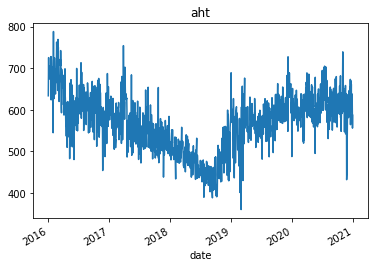

In [22]:
ax = df['aht'].plot()
plt.title('aht')
plt.show()

# How has handle time and Volume changed over time?

The handle time and volume appear to follow the same seasonality, with matching peaks and troughs.

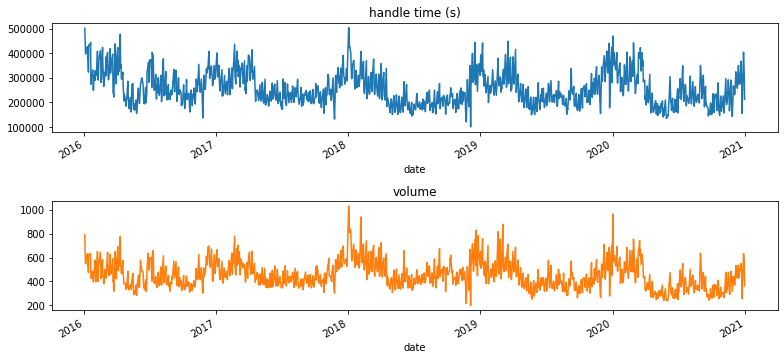

In [23]:
plt.figure(figsize=(11,7))
plt.subplot(311)
df['handle_time'].plot(color='#1f77b4')
plt.title('handle time (s)')
plt.subplot(312)
df['volume'].plot(color='#ff7f0e')
plt.title('volume')
plt.tight_layout()
plt.show()

# What is the relationship between volume and handle time?
There is a strong linear relationship between volume and handle time. As volume increases, total handle time increases, while higher volumes have more variable handle times. The scatter plot below confirms the intuition.

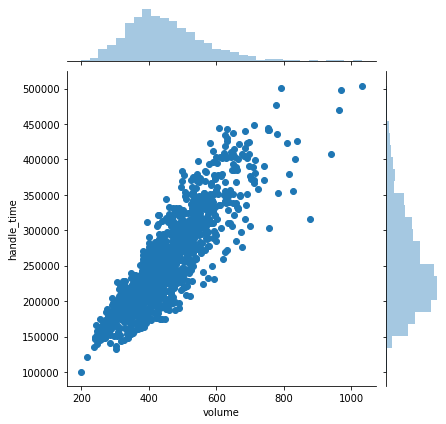

In [24]:
_ = sns.jointplot(x='volume', y='handle_time', data=df)

# What is the relationship between volume and aht?
There is a very weak linear relationship that is nearly flat.  As volume increases, aht decreases slightly.

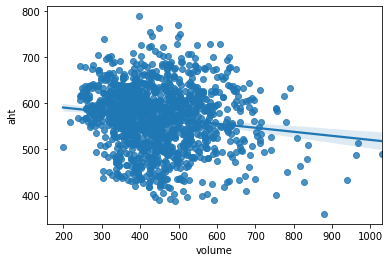

In [25]:
_ = sns.regplot(data=df,x='volume', y='aht' )

# What is the relationship between handle time and aht?
There is a strong linear relationship; As the total handle time increases, the aht tends to increase.

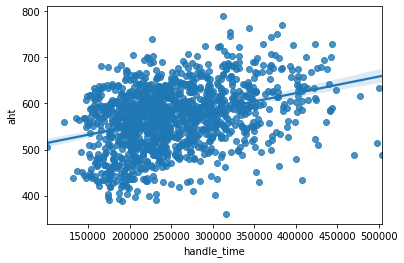

In [26]:
_ = sns.regplot(data=df,x='handle_time', y='aht' )

In [27]:
# validate aht forecast is only null where handle_time_forecast is null 
(df[df['handle_time_forecast'].notnull()].index == df[df['aht_forecast'].notnull()].index).all()

True

# What date do the forecasts begin?


In [28]:
df[df['aht_forecast'].notnull()].head(1)

,Unnamed: 0,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast
date,,,,,,,,
2020-06-01,15420,2020-06-01,139629.0,195989.0,248.0,342.0,563.020161,573.067251


# What are the summary statistics of volume, handle time and aht?
- The median volume is `447`

- The median handle time is `252,102 seconds` or `70 hours`

- The median aht is around `577 seconds` or `9.6 minutes` per call

In [29]:
df[['volume', 'handle_time', 'aht']].describe()

,volume,handle_time,aht
count,1259.000000,1259.000000,1259.000000
mean,446.752184,253225.262113,569.224269
std,110.913545,66136.158488,68.751011
min,199.000000,100626.000000,360.345103
25%,369.000000,203666.000000,524.905036
50%,432.000000,240648.000000,576.646370
75%,510.000000,294855.000000,615.498612
max,1030.000000,503949.000000,788.646465


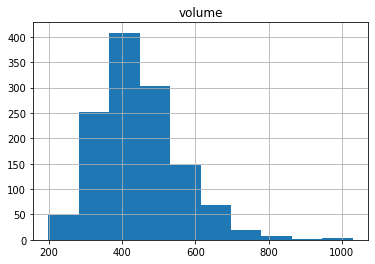

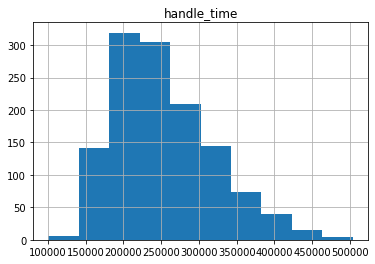

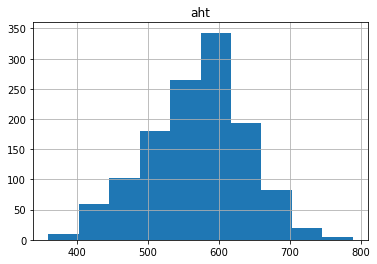

In [30]:
for col in ['volume', 'handle_time', 'aht']:
    df[col].hist()
    plt.title(col)
    plt.show()

# Step 3: Create Training Data and Fit Model for handle time
In order to train our model, we need to define a start and end date for the training data.
Typically, training should be performed with the most relevant or recent data.

In [44]:
# create a new dataframe with 2 columns, date and actual volume received
df['date'] = df.index
df = df[['date', 'handle_time']]

# Must pre-format column names
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2016-03-10']

# set end date of training data
df = df[df['ds'] < '2020-06-01']
df.head()

KeyError: "['handle_time'] not in index"

# Begin Training Model
Since this is the first model, only the default settings will be used. These settings, or hyperparameters can be tuned later, and will be a part of the model's feature engineering. Refer to the Prophet documentation at the [top of the page](#docs)

In [32]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

# Create future dates
This function allows us to create the future dates that we want to predict. We will start with creating the next hundred days after August 13, 2020.

In [33]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1258,2020-12-11
1259,2020-12-12
1260,2020-12-13
1261,2020-12-14
1262,2020-12-15


In [34]:
# get rid of holidays and weekends
future = future[(~future['ds'].isin(h.iloc[:,0].tolist())) & (~future['ds'].dt.weekday.isin([5,6]))]

# Make Predicitons on future dates

In [35]:
forecast = m.predict(future)

# view only the last 5 predictions with confidence intervals 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1197,2020-12-09,289935.958159,244124.526514,340166.958723
1198,2020-12-10,290969.408267,242805.694045,336259.853725
1199,2020-12-11,301345.556655,252287.358888,347548.384711
1200,2020-12-14,367748.488305,318818.204835,417827.841611
1201,2020-12-15,338139.587752,291379.358436,386424.741488


# Visualize handle time seasonality and analyze trends.
The dark blue line is the prediction, the light blue line is the confidence interval, and the black dots is the actual volume. 

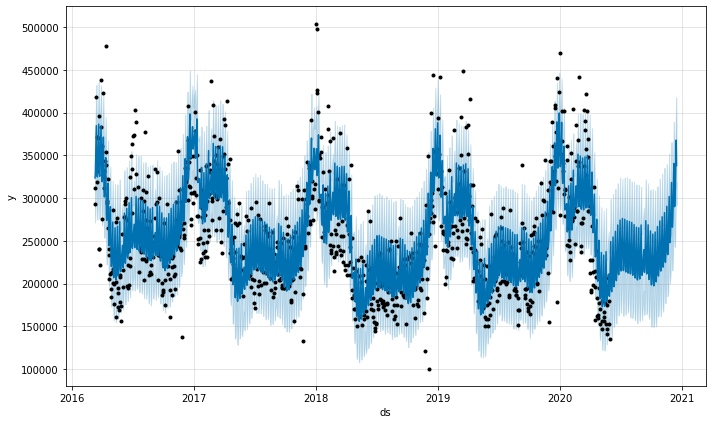

In [36]:
fig1 = m.plot(forecast)

# What is the trend and seasonality for handle time?

<b>Trend</b>: The handle time was decreasing in 2018 then began rising sharply into 2019 and 2020.

<b>Weekly</b>: Monday is the highest handle time decreasing to wednesday and thursday is the lowest with an slight increase again on Friday.

<b>Yearly</b>: The yearly seasonality shows the highest handle time at the beginning and even more so at the end of the calendar year, with a hump in March and a lull throughout the summer and into the fall.

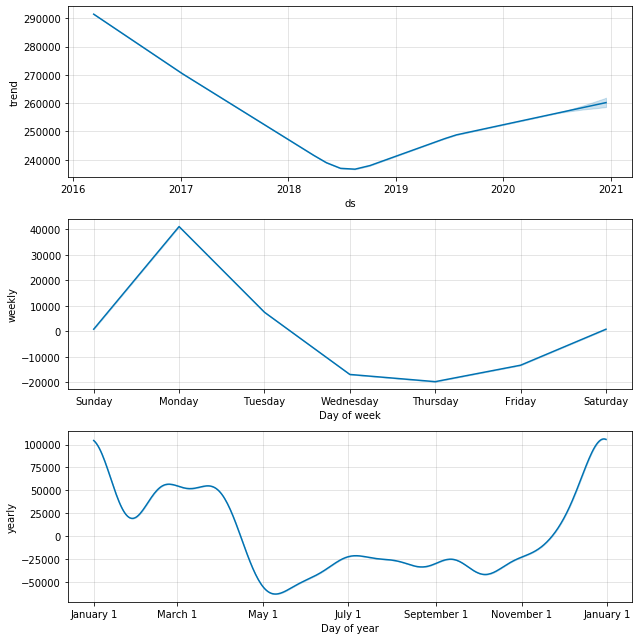

In [37]:
fig2 = m.plot_components(forecast)

# Step 4: Calculate model performance metrics for original model and prophet

In [41]:
# set forecast beginning and end date
f = forecast.copy()
f = f[(forecast['ds'] >= '2020-06-01')]

# create validation dataset
df2 = df1.copy()
df2['ds'] = pd.to_datetime(df2.index.date) 

# set start date of validation data equal to June 1st, 2020
df2 = df2[df2['ds'] >= '2020-06-01']

# remove weekends and holidays
df2 = df2[~df2.index.isin(h.iloc[:,0].tolist())]

In [42]:
def validate_dates(f, df2):
    """
    take in forecast, f
    and dataframe df2 and return Bool
    """
    res = []
    # validate forecast dates shape equals actual dates shape
    v1 = df2.shape[0] == f.shape[0]
    if not v1:
        return False
    else: res.append(v1)
        
    # validate all dates for forecast equal actual dates
    res.append(all(df2['ds'].dt.date.values == f['ds'].dt.date.values))
    
    return all(res)

print(validate_dates(f, df2))

False


# What is the mean absolute error (MAE) of each model?
The prophet model outperformed the current model on test data from June 1st, 2020 through October 26th, 2020 with MAE of 43,696 seconds compared to 48,697 seconds, a difference of 5001 seconds or about 83 minutes.

In [43]:
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(df2['handle_time'], df2['handle_time_forecast'])
mae2 = mean_absolute_error(df2['handle_time'], f['yhat'])
diff = mae1- mae2
pd.DataFrame(index=['old model', 'prophet', 'difference'], 
             data=[int(mae1), int(mae2), int(diff)],
             columns=['MAE (seconds)'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Take a look at the 10 most recent predictions and compare to actual and forecasted volumes.

In [39]:
f.index = f['ds']
df2['prophet'] = f['yhat']

In [40]:
df2[['prophet', 'handle_time', 'handle_time_forecast']].tail(10)

,prophet,handle_time,handle_time_forecast
date,,,
2020-10-13,294735.999695,309408.0,256022.0
2020-10-14,271101.809693,320656.0,242875.0
2020-10-15,269313.557456,238023.0,223809.0
2020-10-16,276541.272705,269197.0,222416.0
2020-10-19,335622.465505,371905.0,296161.0
2020-10-20,302090.352078,273709.0,250820.0
2020-10-21,278492.293696,212237.0,241279.0
2020-10-22,276664.158873,209126.0,221667.0
2020-10-23,283786.031518,203810.0,219499.0


# Step 4: Predict Volume

In [122]:
# copy raw data
df = df1.copy()

# remove holidays
df = df[~df.index.isin(h.iloc[:,0].tolist())]

# validate no weekends or holidays
(df.index.weekday.isin([5,6]).any(),
df.index.isin(h.iloc[:,0].tolist()).any())

(False, False)

In [123]:
df['volume'].describe()

count    1222.000000
mean      462.745499
std       115.172611
min         0.000000
25%       388.000000
50%       447.000000
75%       521.000000
max      1030.000000
Name: volume, dtype: float64

In [124]:
df = df[~df['volume'] < 250]

In [125]:
# create a new dataframe with 2 columns, date and actual volume received
df['date'] = df.index
df = df[['date', 'volume']]

# Must pre-format column names
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2019-03-01']

# set end date of training data
df = df[df['ds'] < '2020-06-01']
df.head()

,ds,y
date,,
2019-03-01,2019-03-01,522
2019-03-04,2019-03-04,878
2019-03-05,2019-03-05,582
2019-03-06,2019-03-06,496
2019-03-07,2019-03-07,483


In [126]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

In [127]:
future = m.make_future_dataframe(periods=200)
future.tail()

,ds
510,2020-12-11
511,2020-12-12
512,2020-12-13
513,2020-12-14
514,2020-12-15


In [128]:
# get rid of holidays and weekends
future = future[(~future['ds'].isin(h.iloc[:,0].tolist())) & (~future['ds'].dt.weekday.isin([5,6]))]

In [129]:
forecast = m.predict(future)

# view only the last 5 predictions with confidence intervals 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
449,2020-12-09,510.257365,423.582018,589.268925
450,2020-12-10,514.580801,428.838731,594.629371
451,2020-12-11,526.333859,440.199404,620.793527
452,2020-12-14,651.105174,572.637121,734.999053
453,2020-12-15,575.326700,491.425780,664.354718


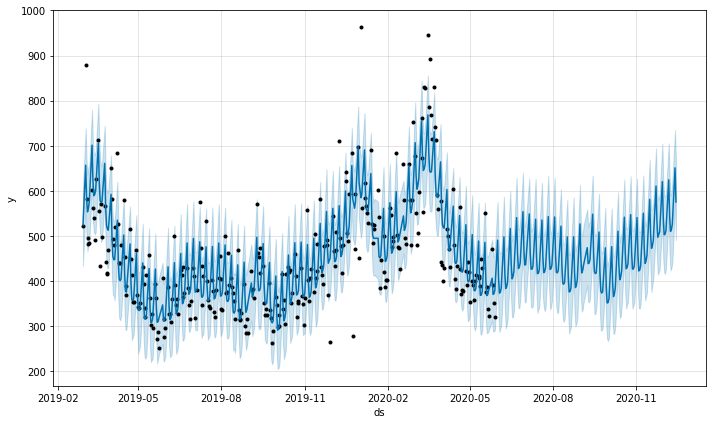

In [130]:
fig1 = m.plot(forecast)

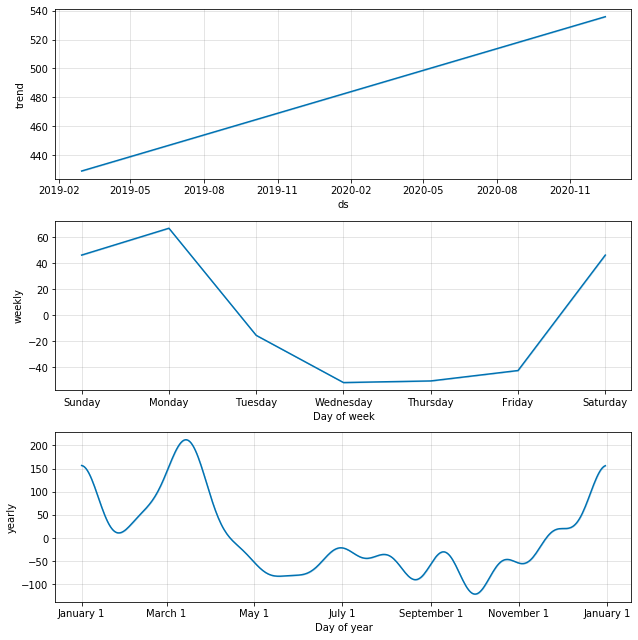

In [131]:
fig2 = m.plot_components(forecast)

In [132]:
# set forecast beginning and end date
f = forecast.copy()
f = f[(forecast['ds'] >= '2020-06-01') & (f['ds'] <= '2020-10-26')]

# create validation dataset
df2 = df1.copy()
df2['ds'] = pd.to_datetime(df2.index.date) 

# set start date of validation data equal to June 1st, 2020
df2 = df2[df2['ds'] >= '2020-06-01']

# remove weekends and holidays
df2 = df2[~df2.index.isin(h.iloc[:,0].tolist())]

In [133]:
validate_dates(f,df2)

True

In [134]:
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(df2['volume'], df2['volume_forecast'])
mae2 = mean_absolute_error(df2['volume'], f['yhat'])
diff = mae1- mae2
pd.DataFrame(index=['old model', 'prophet', 'difference'], 
             data=[int(mae1), int(mae2), int(diff)],
             columns=['MAE (volume)'])

,MAE (volume)
old model,71
prophet,67
difference,4


# Create functions for new PSG forecast

True


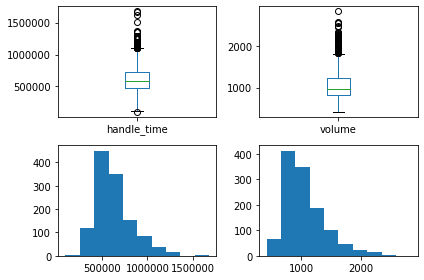

,ds,y
date,,
2016-03-10,2016-03-10,557265.0
2016-03-11,2016-03-11,611462.0
2016-03-14,2016-03-14,842770.0
2016-03-15,2016-03-15,666242.0
2016-03-16,2016-03-16,651637.0


{'old': 82164.5, 'prophet': 75448.59510956233}


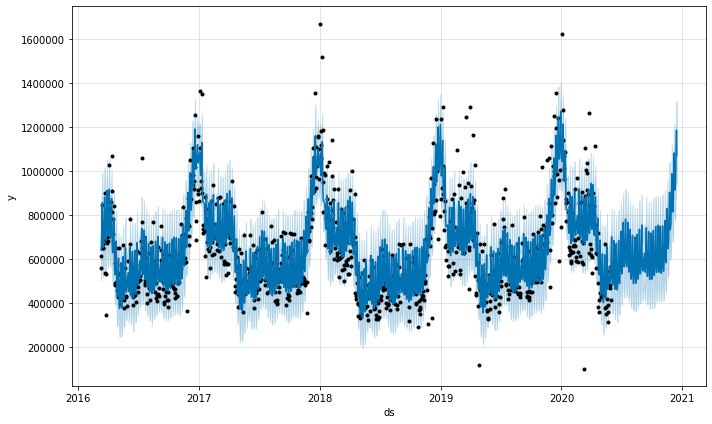

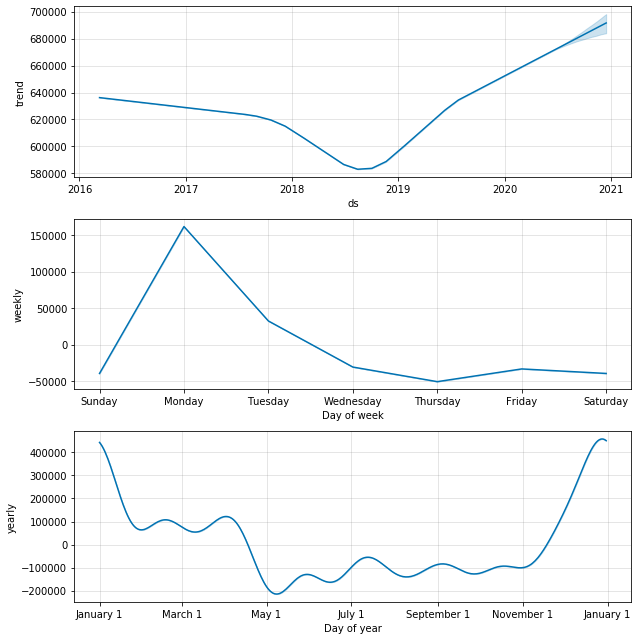

In [143]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error

def plot_time_vol(df):
    plt.subplot(221)
    df['handle_time'].plot.box()

    plt.subplot(222)
    df['volume'].plot.box()

    plt.subplot(223)
    df['handle_time'].hist(grid=False)

    plt.subplot(224)
    df['volume'].hist(grid=False)
    plt.tight_layout()
    plt.show()

def validate_holidays(df):
    # validate no weekends or holidays
    return (df.index.weekday.isin([5,6]).any(),
    df.index.isin(h.iloc[:,0].tolist()).any()) == (False, False)

def create_training_data(df, kpi, start_date, end_date):
    # create a new dataframe with 2 columns, date and actual volume received
    df['date'] = df.index
    df = df[['date', kpi]]

    # Must pre-format column names
    df.columns = ['ds','y']

    # set start date of training data
    df = df[df['ds'] >= start_date]

    # set end date of training data
    df = df[df['ds'] < end_date]

    return df

def create_forecast(df,periods=200):
    # create default prophet model
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)

    future = m.make_future_dataframe(periods=periods)
    # display(future.tail())

    # get rid of holidays and weekends
    future = future[(~future['ds'].isin(h.iloc[:,0].tolist())) & (~future['ds'].dt.weekday.isin([5,6]))]

    return m,future

def plot_forecast(forecast):
    # view only the last 5 predictions with confidence intervals 
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    fig1 = m.plot(forecast)

    fig2 = m.plot_components(forecast)

def set_forecast(forecast, df1, start_date, end_date):
    # set forecast beginning and end date
    f = forecast.copy()
    f = f[(forecast['ds'] >= start_date) & (f['ds'] <= end_date)]

    # create validation dataset
    df2 = df1.copy()
    df2['ds'] = pd.to_datetime(df2.index.date) 

    # set start date of validation data equal to June 1st, 2020
    df2 = df2[df2['ds'] >= start_date]

    # remove weekends and holidays
    df2 = df2[~df2.index.isin(h.iloc[:,0].tolist())]
    df2 = df2[~df2.index.weekday.isin([5,6])]
    
    return f, df2

def validate_dates(f, df2):
    """
    take in forecast, f
    and dataframe df2 and return Bool
    """
    res = []
    # validate forecast dates shape equals actual dates shape
    v1 = df2.shape[0] == f.shape[0]
    if not v1:
        return False
    else: res.append(v1)
        
    # validate all dates for forecast equal actual dates
    res.append(all(df2['ds'].dt.date.values == f['ds'].dt.date.values))
    
    return all(res)

def evaluate_model(forecast, kpi, metric='mae'):
    if metric == 'mae':
        mae1 = mean_absolute_error(df2[kpi], df2[kpi+'_forecast'])
        mae2 = mean_absolute_error(df2[kpi], f['yhat'])
        diff = mae1- mae2
        return {'old': mae1, 'prophet': mae2}
    else:
        return 'invalid metric'


# Load Data
df = pd.read_csv('psg_aht_vol.csv', parse_dates=['date'],
                index_col=['date'], usecols=range(5), header=1,
                names=['date', 'handle_time', 'handle_time_forecast', 
                       'volume','volume_forecast'])
df1 = df.copy()
h = pd.read_csv('holidays.csv')

# remove holidays
df = df[~df.index.isin(h.iloc[:,0].tolist())]

# remove weekends
df = df[~df.index.weekday.isin([5,6])]
print(validate_holidays(df))

# remove outliers
df = df[df['handle_time'] > 10000]

# plot data
plot_time_vol(df)

# create training
df = create_training_data(df, 'handle_time', '2016-03-10', '2020-06-01')

# plot forecast
display(df.head())
m,future = create_forecast(df)
forecast = m.predict(future)
plot_forecast(forecast)

# set forecast beginning and end date
f = forecast.copy()
f = f[(forecast['ds'] >= '2020-06-01') & (f['ds'] <= '2020-10-18')]

# create validation dataset
df2 = df1.copy()
df2['ds'] = pd.to_datetime(df2.index.date) 

# set start date of validation data equal to June 1st, 2020
df2 = df2[df2['ds'] >= '2020-06-01']

# remove weekends and holidays
df2 = df2[~df2.index.isin(h.iloc[:,0].tolist())]
df2 = df2[~df2.index.weekday.isin([5,6])]

# Validate test data
if validate_dates(f, df2):
    mae = evaluate_model(f, 'handle_time', metric='mae')
    print(mae)
#     display(pd.DataFrame(index=['old model', 'prophet', 'difference'], 
#                  data=[int(mae1), int(mae2), int(mae1-mae2)],
#                  columns=['MAE (volume)']))
else:
    print('invalid dates')
    

# Show 10 most recent forecasts

In [72]:
f.index = f['ds']

df2['prophet'] = f['yhat']

df2[['handle_time_forecast', 'handle_time', 'prophet']].head(10)

,handle_time_forecast,handle_time,prophet
date,,,
2020-06-01,585134.0,517114.0,700379.745145
2020-06-02,456986.0,440438.0,569360.888723
2020-06-03,396844.0,500584.0,504197.988396
2020-06-04,394242.0,409230.0,481785.380193
2020-06-05,413129.0,528545.0,496521.003183
2020-06-08,521123.0,705950.0,682796.960056
2020-06-09,441713.0,649607.0,550329.780197
2020-06-10,489677.0,490487.0,484404.251576
2020-06-11,424040.0,502604.0,461927.421782


In [173]:
print('diff:', int(82164.5 - 75448.59510956233), 'sec', 'or', 
      int((82164.5 - 75448.59510956233)/60), 'minutes', 'or',
str(round((82164.5 - 75448.59510956233)/82164.5*100,2))+'%')


diff: 6715 sec or 111 minutes or 8.17%


# PSG Model Performance
The new model is performing better on the metric mean absolute error of the handle time kpi by approximately 6716 seconds, or about 112 minutes, or an 8% improvement.

# Test Python script

In [259]:
!python run_model.py bro_aht_vol.csv handle_time 2016-03-10 2020-06-01

Initial log joint probability = -11.4769
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2287.73   0.000478099       50.5622           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       2288.63   0.000200106       64.7862   1.811e-06       0.001      261  LS failed, Hessian reset 
     192       2288.85   0.000208469       63.9412   3.949e-06       0.001      315  LS failed, Hessian reset 
     199       2288.87   7.00899e-05       52.6781      0.2904           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238        2288.9   1.12998e-07        60.635      0.8126      0.2242      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

Mean Absolute Error
{'old': 48697.394230769234, 'prophet': 43848.47174106349}
division: bro k